In [1]:
#### MAY NEED TO REMOVE --> THESE IMPORTS ARE JUST FOR MY DEPENDENCIES ON MY LOCAL DEVICE
import sys 
sys.path.append('../..')
######

from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import matplotlib.pyplot as plt
import seaborn as sns
import torch as ch
from torch import Tensor
from torch import sigmoid as sig
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm.autonotebook import tqdm as tqdm
from abc import ABC
import IPython
import os
import dill

from delphi import train
from delphi.oracle import oracle
import delphi.utils.constants as consts
# set environment variable so that stores can create output files

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.cuda.FloatTensor)
    print("cuda tensors...")

cuda tensors...


# Constants

In [2]:
# store path
EXP_NAME = 'lr1e-2'
SOFTMAX_REGRESSION_STORE_PATH = '/home/gridsan/stefanou/SoftmaxRegression/' + EXP_NAME

# tables
STANDARD_STORE_TABLE = 'standard_table'
TRUNCATED_STORE_TABLE = 'truncated_table'
GUMBEL_CE_TABLE = 'gumbel_table'

STANDARD_EVAL_TABLE = 'standard_eval_table'
TRUNCATED_EVAL_TABLE = 'truncated_eval_table'
GUMBEL_EVAL_TABLE = 'gumbel_eval_table'


TRUNC_TRUTH_TABLE ='truncated_truth_table'
NAIVE_TRUTH_TABLE = 'naive_truth_table'

# Algorithm and Experiment Hyperparameters

In [3]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 8, 
    'batch_size': 50,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-2,
    'shuffle': False, 
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 50,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': .9,
    'weight_decay': 5e-4,
    'custom_lr_multiplier': consts.CYCLIC,
    'shuffle': True,
    'device': 'cpu',
    'alpha_thresh': .2,
#     'score': True, 
    'var': True, 
#     'tol': 5e-2,
#     'step_lr': True, 
#     'step_lr_gamma': .9,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("cuda available...")
else: 
    args.__setattr__('device', 'cpu')
args

cuda available...


{
  "epochs": 25,
  "num_workers": 8,
  "batch_size": 50,
  "bias": true,
  "num_samples": 1000,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.01,
  "shuffle": true,
  "samples": 10000,
  "in_features": 2,
  "k": 2,
  "lower": -1,
  "upper": 1,
  "trials": 50,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "validation_split": 0.8,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "custom_lr_multiplier": "cyclic",
  "device": "cuda",
  "alpha_thresh": 0.2,
  "var": true
}

# Training and Evaluation Procedure Functions

In [4]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1)
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

# Oracles

In [5]:
class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()
    
class DNN_Logit_Ball(oracle): 
    """
    Truncation ball placed on DNN logits.
    INTUITION: logits that are neither very large nor very small insinuate
    that the classification is not 
    """
    def __init__(self, lower, upper): 
        self.lower = lower 
        self.upper = upper
        
    def __call__(self, x): 
        return ((x < self.lower) | (x > self.upper)).float()
        

class Identity(oracle): 
    """
    Identity membership oracle for DNNs. All logits are accepted within the truncation set.
    """
    def __call__(self, x): 
        return ch.ones(x.size())
    
lower = DNN_Lower(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32))
id_ = Identity()
ball = DNN_Logit_Ball(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32), ch.full(ch.Size([args.K,]), 2, dtype=ch.float32))

# Binary Cross Entropy Gradients

In [6]:
class LogisticBCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.BCEWithLogitsLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors

        # logistic distribution
        base_distribution = Uniform(0, 1)
        transforms_ = [SigmoidTransform().inv]
        logistic = TransformedDistribution(base_distribution, transforms_)

        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)
        rand_noise = logistic.sample(stacked.size())
        # add noise
        noised = stacked + rand_noise
        noised_labs = noised > 0
        # filter
        mask = (noised_labs).eq(targ)
        inner_sig = (sig(rand_noise))
        avg = 1 - 2*((inner_sig*mask).sum(0) / (mask.sum(0) + 1e-5))
        return avg, None
    
logistic_bce = LogisticBCE.apply
from torch.nn import BCEWithLogitsLoss; bce_logit = BCEWithLogitsLoss()

In [7]:
class TruncatedBCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.BCEWithLogitsLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors

        # logistic distribution
        base_distribution = Uniform(0, 1)
        transforms_ = [SigmoidTransform().inv]
        logistic = TransformedDistribution(base_distribution, transforms_)

        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)
        # add noise
        noised = stacked + logistic.sample(stacked.size())
        # filter
        filtered = ch.stack([args.phi(batch) for batch in noised]).float()
        out = (noised * filtered).sum(dim=0) / (filtered.sum(dim=0) + 1e-5)
        grad = ch.where(ch.abs(out) > 1e-5, sig(out), targ) - targ
        return grad / pred.size(0), -grad / pred.size(0)
trunc_bce = TruncatedBCE.apply

Check the Cosine Similarity Between Logistic BCE, TruncatedBCE with Identity Oracle, and BCEWithLogits

In [8]:
# generate random uniform weights
ground_truth = nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
ground_truth.weight = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1, args.in_features])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

# logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
z = ground_truth(X) + logistic.sample(ch.Size([X.size(0), 1]))
y = ch.where(z > 0, ch.ones(1), ch.zeros(1))

# truncate data
args.__setattr__('phi', id_)
indices = ch.all(args.phi(z).bool(), dim=1).nonzero(as_tuple=False).flatten()
x_trunc = X[indices]
y_trunc = y[indices]

print("alpha: ", x_trunc.size(0) / X.size(0))

# pass data through model
model = ch.nn.Linear(in_features=2, out_features=1)
pred = model(x_trunc)

gt_loss = bce_logit(pred, y_trunc)
gt_g, = ch.autograd.grad(gt_loss, [pred])

log_loss = logistic_bce(pred, y_trunc)
log_g, = ch.autograd.grad(log_loss, [pred])

trunc_loss = trunc_bce(pred, y_trunc)
trunc_g, = ch.autograd.grad(trunc_loss, [pred])

print('Cosine Similarity between logistic bce and logits bce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(log_g.T, gt_g.T))

print('Cosine Similarity between trunc bce (identity oracle) and logits bce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(trunc_g.T, gt_g.T))

alpha:  1.0
Cosine Similarity between logistic bce and logits bce gradient:  tensor([0.9996])
Cosine Similarity between trunc bce (identity oracle) and logits bce gradient:  tensor([0.9999])


Check the Cosine Similarity Between Logistic BCE, TruncatedBCE, and BCEWithLogits on Truncated Data

In [ ]:
# generate random uniform weights
ground_truth = nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
ground_truth.weight = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1, args.in_features])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

# logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
z = ground_truth(X) + logistic.sample(ch.Size([X.size(0), 1]))
y = ch.where(z > 0, ch.ones(1), ch.zeros(1))

# truncate data
args.__setattr__('phi', ball)
indices = ch.all(args.phi(z).bool(), dim=1).nonzero(as_tuple=False).flatten()
x_trunc = X[indices]
y_trunc = y[indices]

print("alpha: ", x_trunc.size(0) / X.size(0))

# pass data through model
model = ch.nn.Linear(in_features=2, out_features=1)
pred = model(x_trunc)

gt_loss = bce_logit(pred, y_trunc)
gt_g, = ch.autograd.grad(gt_loss, [pred])

log_loss = logistic_bce(pred, y_trunc)
log_g, = ch.autograd.grad(log_loss, [pred])

trunc_loss = trunc_bce(pred, y_trunc)
trunc_g, = ch.autograd.grad(trunc_loss, [pred])

print('Cosine Similarity between logistic bce and logits bce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(log_g.T, gt_g.T))

print('Cosine Similarity between trunc bce and logits bce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(trunc_g.T, gt_g.T))

# Cross Entropy Gradients

In [9]:
class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        
        pred, targ = ctx.saved_tensors
        # gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
    
gumbel_ce = GumbelCE.apply
from torch.nn import CrossEntropyLoss; ce_loss = CrossEntropyLoss()

In [10]:
class TruncatedCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
#         import pdb; pdb.set_trace()
        
        pred, targ = ctx.saved_tensors
        # initialize gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        filtered = ch.all(args.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)
        
        first = inner_exp * mask
        second = inner_exp * filtered
        
        mask_sum = mask.sum(0)
        filter_sum = filtered.sum(0)
        
        avg = ((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5)) - ((inner_exp * filtered).sum(0) / (filtered.sum(0) + 1e-5)) 
        return -avg / pred.size(0), None
trunc_ce = TruncatedCE.apply

Now, we can see that when we use a different truncation mechansim, the GumbelCE and CE Gradients remain very similar, but the TruncatedCE accounts for the bias in the data

In [11]:
# generate random uniform weights
ground_truth = nn.Linear(in_features=args.in_features, out_features=args.k, bias=args.bias)
ground_truth.weight = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([args.k, args.in_features])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

# logistic distribution
gumbel = Gumbel(0, 1)

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
z = ground_truth(X) + gumbel.sample(ch.Size([X.size(0), 1]))
y = z.argmax(-1)

args.__setattr__('phi', id_)
# truncate
indices = ch.all(args.phi(z).bool(), dim=1).nonzero(as_tuple=False).flatten()
x_trunc = X[indices]
y_trunc = y[indices]

print("alpha: ", x_trunc.size(0) / X.size(0))

# pass data through model
model = ch.nn.Linear(in_features=args.in_features, out_features=args.k)
pred = model(x_trunc)

gt_loss = ce_loss(pred, y_trunc)
gt_g, = ch.autograd.grad(gt_loss, [pred])

gum_loss = gumbel_ce(pred, y_trunc)
gum_g, = ch.autograd.grad(gum_loss, [pred])


trunc_loss = trunc_ce(pred, y_trunc)
trunc_g, = ch.autograd.grad(trunc_loss, [pred])

print('Cosine Similarity between gumbel ce and ce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(gum_g.T, gt_g.T))

print('Cosine Similarity between trunc ce (identity oracle) and ce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(trunc_g.T, gt_g.T))

alpha:  1.0
Cosine Similarity between gumbel ce and ce gradient:  tensor([0.9979, 0.9956])
Cosine Similarity between trunc ce (identity oracle) and ce gradient:  tensor([0.9984, 0.9972])


Now, we can see that when we use a different truncation mechansim, the GumbelCE and CE Gradients remain very similar, but the TruncatedCE accounts for the bias in the data

In [12]:
# generate random uniform weights
ground_truth = nn.Linear(in_features=args.in_features, out_features=args.k, bias=args.bias)
ground_truth.weight = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([args.k, args.in_features])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

# logistic distribution
gumbel = Gumbel(0, 1)

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
z = ground_truth(X) + gumbel.sample(ch.Size([X.size(0), 1]))
y = z.argmax(-1)

# truncate
args.__setattr__('phi', ball)
indices = ch.all(args.phi(z).bool(), dim=1).nonzero(as_tuple=False).flatten()
x_trunc = X[indices]
y_trunc = y[indices]

print("alpha: ", x_trunc.size(0) / X.size(0))

# pass data through model
model = ch.nn.Linear(in_features=args.in_features, out_features=args.k)
pred = model(x_trunc)

gt_loss = ce_loss(pred, y_trunc)
gt_g, = ch.autograd.grad(gt_loss, [pred])

gum_loss = gumbel_ce(pred, y_trunc)
gum_g, = ch.autograd.grad(gum_loss, [pred])


trunc_loss = trunc_ce(pred, y_trunc)
trunc_g, = ch.autograd.grad(trunc_loss, [pred])

print('Cosine Similarity between gumbel ce and ce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(gum_g.T, gt_g.T))

print('Cosine Similarity between trunc ce and ce gradient: ',
        ch.nn.CosineSimilarity(dim=1)(trunc_g.T, gt_g.T))

alpha:  0.2227
Cosine Similarity between gumbel ce and ce gradient:  tensor([0.9972, 0.9943])
Cosine Similarity between trunc ce and ce gradient:  tensor([0.7274, 0.5750])


# Experiment

In [13]:
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
            ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices].cpu(), y[indices].cpu()
            alpha = x_trunc.size(0) / X.size(0)

            # all synthetic data 
            ds = TensorDataset(x_trunc, y_trunc)
            # split ds into training and validation data sets - 80% training, 20% validation
            train_length = int(len(ds)*.8)
            val_length = len(ds) - train_length
            train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
            # train and validation loaders
            train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

            # test dataset
            x_test = X[~indices].cpu()
            y_test = y[~indices].cpu()
            test_ds = TensorDataset(x_test, y_test)
            test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            
    return ground_truth, (train_loader, val_loader), test_loader

In [ ]:
# set truncation oracle
args.__setattr__('phi', ball)

# perform number of trials experiments
for i in range(args.trials):
    # create store
    out_store = Store(SOFTMAX_REGRESSION_STORE_PATH)
    trunc_epoch_hook = epoch_hook(out_store, table_name=TRUNC_TRUTH_TABLE)
    naive_epoch_hook = epoch_hook(out_store, table_name=NAIVE_TRUTH_TABLE)

#     args.__setattr__('score', True)
    # generate data for exp
    ground_truth, loaders, test_loader = gen_data()
    # set ground-truth
    trunc_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', trunc_epoch_hook)

    # new classifier models at the beginning of each trial
    trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
    train.train_model(args, trunc_multi_log_reg, loaders, store=out_store, 
                table=TRUNCATED_STORE_TABLE)
    
    # set ground-truth
    naive_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', naive_epoch_hook)
    
    # new classifier models at the beginning of each trial
    standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # naive ce loss
    args.__setattr__('custom_criterion', ch.nn.CrossEntropyLoss()) # default ce loss
    train.train_model(args, standard_multi_log_reg, loaders, store=out_store, 
                table=STANDARD_STORE_TABLE)
    
    # Gumbel CE store path 
    args.__setattr__('custom_criterion', gumbel_ce)
    gumbel_ce_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
    train.train_model(args, gumbel_ce_multi_log_reg, loaders, store=out_store, table=GUMBEL_CE_TABLE)

    # standard multinomial logistic regression eval - if there is a test set
    if len(test_loader.dataset) > 0:
        args.__setattr__('score', False)
        # truncated multinomial logistic regression eval
        train.eval_model(args, trunc_multi_log_reg, test_loader, out_store, table=TRUNCATED_EVAL_TABLE)
        # clear output
        
        # standard multinomial logistic regression eval
        train.eval_model(args, standard_multi_log_reg, test_loader, out_store, table=STANDARD_EVAL_TABLE)
    
    IPython.display.clear_output(wait=False)


    # close store after experiment
    out_store.close()

Logging in: /home/gridsan/stefanou/SoftmaxRegression/lr1e-2/7932ac9d-06d5-4bce-aac8-5bd599478afc


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

In [6]:
def plot():
    reader = CollectionReader(SOFTMAX_REGRESSION_STORE_PATH)

    # TRUNCATED CE LOSS DATA
    trunc_logs = reader.df(TRUNCATED_STORE_TABLE)
    trunc_truth_table = reader.df(TRUNC_TRUTH_TABLE)

    # STANDARD CE LOSS DATA
    standard_logs = reader.df(STANDARD_STORE_TABLE)
    standard_truth_table = reader.df(NAIVE_TRUTH_TABLE)

    sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
    sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
    ax.set(xlabel='Epoch', ylabel='CE Loss')
    plt.show()

    sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
    sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    plt.show()
    
    sns.lineplot(data=standard_truth_table, x='epoch', y='cos_sim', label='Naive Cosine Similarity')
    ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='cos_sim', label='Truncated Cosine Similarity')
    ax.set(xlabel='Epoch', ylabel='Cosine Similarity')
    plt.show()
    
    sns.lineplot(data=standard_truth_table, x='epoch', y='l2', label='Naive L2')
    ax = sns.lineplot(data=trunc_truth_table, x='epoch', y='l2', label='Truncated L2')
    ax.set(xlabel='Epoch', ylabel='L2 Distance')
    plt.show()
    
    try: 
        # STANDARD TEST SET RESULTS 
        standard_test_results = reader.df(STANDARD_EVAL_TABLE)
        
        # TRUNCATED TEST SET RESULTS 
        trunc_test_results = reader.df(TRUNCATED_EVAL_TABLE)

        print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
        print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))
    except: 
        print("No Test Results to Report")
        
    reader.close()

100%|██████████| 101/101 [00:09<00:00, 11.06it/s]


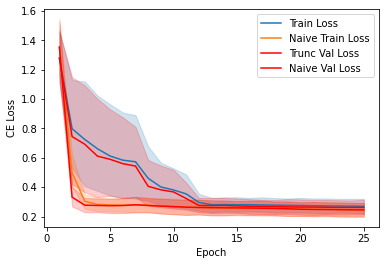

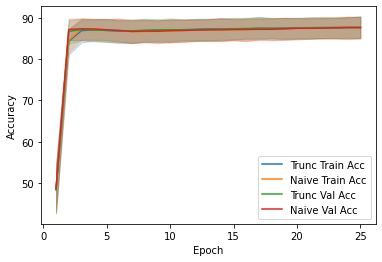

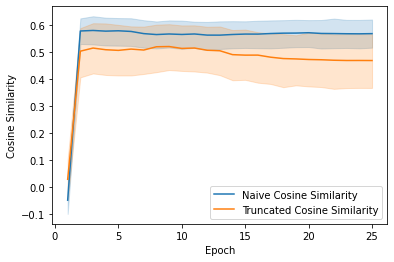

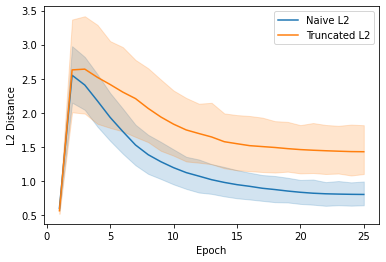

Standard Test Accuracy: 0    88.455597
0    90.524483
0    87.195946
0    87.227501
0    70.524689
       ...    
0    67.042114
0    79.175613
0    80.175247
0    68.032059
0    75.416779
Name: test_prec1, Length: 100, dtype: float64
Truncated Test Accuracy: 0    88.262550
0    90.349655
0    87.229729
0    88.177750
0    70.473251
       ...    
0    66.846230
0    85.057968
0    80.029205
0    67.297417
0    75.416779
Name: test_prec1, Length: 100, dtype: float64


In [10]:
plot()

In [ ]:
gumbel = Gumbel(0, 1)

loss = ch.nn.CrossEntropyLoss()

m = ch.nn.Linear(10, 2)
x = ch.rand(1000, 10)
w = ch.randn(10, 2)

z = x @ w + gumbel.sample([1000, 2])

y = z.argmax(1)

indices = ch.all(phi(z).bool(), dim=1).float().nonzero(as_tuple=False).flatten()

x_trunc, y_trunc = x[indices], y[indices]


out = m(x_trunc)
loss_ = TruncatedGumbelCE.apply(out, y_trunc)
g, = ch.autograd.grad(loss_, [out])

gt_loss = loss(out, y_trunc)
gt_g, = ch.autograd.grad(gt_loss, [out])

print('Correlation between real and estimated gradient: ',
        (gt_g * g).sum() / (gt_g.norm() * g.norm()))

In [10]:
reader = CollectionReader(SOFTMAX_REGRESSION_STORE_PATH)

# TRUNCATED CE LOSS DATA
trunc_logs = reader.df(TRUNCATED_STORE_TABLE)
ground_truth_table = reader.df(GROUND_TRUTH_TABLE)

# STANDARD CE LOSS DATA
standard_logs = reader.df(STANDARD_STORE_TABLE)

100%|██████████| 22/22 [00:02<00:00,  9.19it/s]


ValueError: No objects to concatenate

In [50]:
trunc_logs

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,0.0,0.648162,0.0,0.653060,2.583890,d06e3af8-0366-409f-9289-f74200d6f2bb
1,2,0.0,0.612210,0.0,0.652004,5.397062,d06e3af8-0366-409f-9289-f74200d6f2bb
2,3,0.0,0.606701,0.0,0.636584,7.575831,d06e3af8-0366-409f-9289-f74200d6f2bb
3,1,0.0,2.184799,0.0,2.111340,3.274090,d06e3af8-0366-409f-9289-f74200d6f2bb
4,2,0.0,0.532716,0.0,0.597430,6.459375,d06e3af8-0366-409f-9289-f74200d6f2bb
5,1,0.0,1.301522,0.0,1.315182,3.916513,d06e3af8-0366-409f-9289-f74200d6f2bb
6,2,0.0,0.757114,0.0,1.350304,9.366570,d06e3af8-0366-409f-9289-f74200d6f2bb
7,3,0.0,0.680958,0.0,0.712907,14.784908,d06e3af8-0366-409f-9289-f74200d6f2bb
8,1,0.0,1.001752,0.0,1.018380,2.545462,d06e3af8-0366-409f-9289-f74200d6f2bb
9,2,0.0,1.026217,0.0,1.047058,4.982162,d06e3af8-0366-409f-9289-f74200d6f2bb


In [35]:
def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.cuda.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = Variable(target)
        
    return target

In [38]:
F.one_hot(Tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1]).unsqueeze(0))

RuntimeError: one_hot is only applicable to index tensor.

In [42]:
F.one_hot(Tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1]).long(), num_classes=2)

tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]])